In [1]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

In [3]:
results_path = '/scratch/bmoorema/Results/test/SalishSeaCast_currenttuning_test'

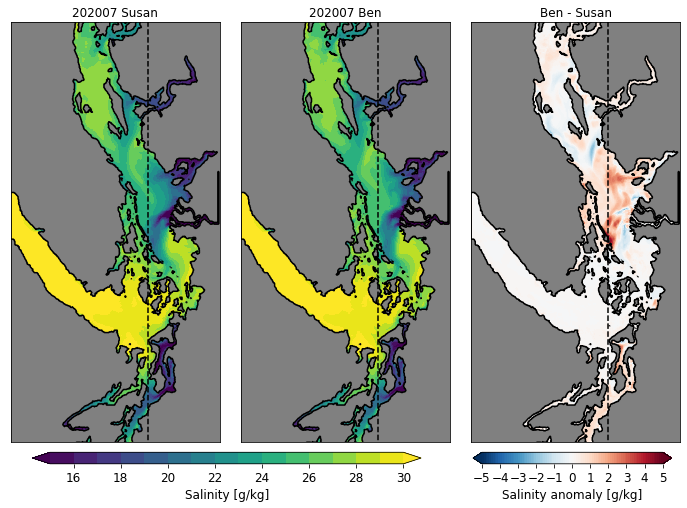

In [18]:
mask = xr.open_dataset('/home/bmoorema/MEOPAR/grid/mesh_mask202108.nc')
S_old = xr.open_dataset(results_path + '/SalishSea_1d_20160101_20160630_grid_T_20160330-20160330.nc')
S_old = S_old.vosaline.isel(time_counter=0, deptht=0).values
S_new = xr.open_dataset(results_path + '/SalishSea_1h_20160101_20160331_grid_T.nc')
S_new = S_new.vosaline.isel(time_counter=slice(-24, None), deptht=0).values.mean(axis=0)
tmask = mask.tmask[0, 0, ...].values

fig, axs = plt.subplots(1, 3, figsize=(12, 8), gridspec_kw={'wspace': 0.1})

for ax, S in zip(axs, [S_old, S_new]):
    c1 = ax.contourf(S, levels=np.arange(15, 31), cmap='viridis', extend='both')
c2 = axs[2].contourf(S_new - S_old, levels=np.arange(-5, 5.1, 0.1), cmap='RdBu_r', extend='both')

for ax, title in zip(axs, ['202007 Susan', '202007 Ben', 'Ben - Susan']):
    
    ax.contourf(tmask, levels=[-0.01, 0.01], colors='gray')
    ax.contour(tmask, levels=[-0.01, 0.01], colors='k')
    ax.set_ylim([50, 750])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_title(title, fontsize=12)
    ax.set_aspect(5/4.4)
    ax.plot([260, 260], [0, 898], 'k--')

cax = fig.add_axes([0.15, 0.1, 0.45, 0.02])
fig.colorbar(c1, cax=cax, label='Salinity [g/kg]', ticks=range(16, 31, 2), orientation='horizontal')

cax = fig.add_axes([0.66, 0.1, 0.23, 0.02])
fig.colorbar(c2, cax=cax, label='Salinity anomaly [g/kg]', ticks=range(-5, 6), orientation='horizontal')

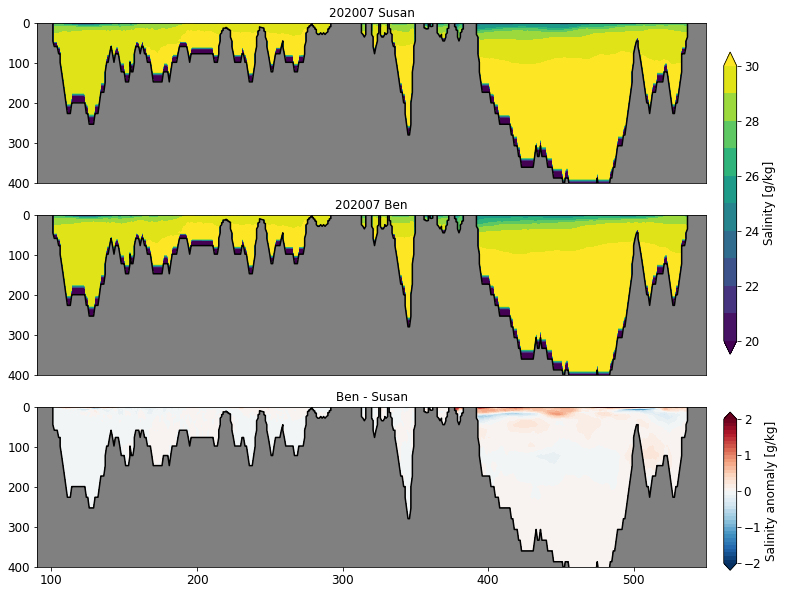

In [35]:
mask = xr.open_dataset('/home/bmoorema/MEOPAR/grid/mesh_mask202108.nc')
S_old = xr.open_dataset(results_path + '/SalishSea_1d_20160101_20160630_grid_T_20160330-20160330.nc')
S_old = S_old.vosaline.isel(time_counter=0, x=260).values
S_new = xr.open_dataset(results_path + '/SalishSea_1h_20160101_20160331_grid_T.nc')
S_new = S_new.vosaline.isel(time_counter=slice(-24, None), x=260).values.mean(axis=0)
tmask, gridy, deptht = mask.tmask[0, ..., 260].values, mask.y.values, mask.gdept_1d[0, :]

fig, axs = plt.subplots(3, 1, figsize=(12, 10), gridspec_kw={'hspace': 0.2})

for ax, S in zip(axs, [S_old, S_new]):
    c1 = ax.contourf(gridy, deptht, S, levels=np.arange(20, 31), cmap='viridis', extend='both')
c2 = axs[2].contourf(gridy, deptht, S_new - S_old, levels=np.arange(-2, 2.1, 0.1), cmap='RdBu_r', extend='both')

for ax, title in zip(axs, ['202007 Susan', '202007 Ben', 'Ben - Susan']):
    
    ax.contourf(gridy, deptht, tmask, levels=[-0.01, 0.01], colors='gray')
    ax.contour(gridy, deptht, tmask, levels=[-0.01, 0.01], colors='k')
    ax.set_xlim([90, 550])
    ax.set_ylim([400, 0])
    ax.set_title(title, fontsize=12)
    if title != 'Ben - Susan': ax.xaxis.set_ticks([])

cax = fig.add_axes([0.92, 0.42, 0.015, 0.42])
fig.colorbar(c1, cax=cax, label='Salinity [g/kg]', ticks=range(20, 31, 2))

cax = fig.add_axes([0.92, 0.12, 0.015, 0.22])
fig.colorbar(c2, cax=cax, label='Salinity anomaly [g/kg]', ticks=range(-2, 3))